In [116]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

folder = '../data'
merge_file = 'prepilot'
plot_folder = '../plots/prepilot'

experiments = [
    {
        'name': 'flextimes',
        'pagetimes': 'PageTimes-2021-12-09.csv',
        'main_part': 'main_part_pilot_2021-12-09.csv',
        'folder': '../data/prepilot'
    },
    {
        'name': 'fixedtimes',
        'pagetimes': 'PageTimes-2021-12-13.csv',
        'main_part': 'main_part_pilot_2021-12-13.csv',
        'folder': '../data/prepilot2'
    }, 
]


dfs = []
dfts = []
for exp in experiments:
    df = pd.read_csv(os.path.join(exp['folder'], exp['main_part']))
    dft = pd.read_csv(os.path.join(exp['folder'], exp['pagetimes']))
    df['experiment_name'] = exp['name']
    dft['experiment_name'] = exp['name']
    dfs.append(df)
    dfts.append(dft)
df = pd.concat(dfs)
dft = pd.concat(dfts)

In [117]:

max_player = 4

# where = (
#     (df['player.id_in_group'] >= 2) & 
#     (df['player.id_in_group'] <= max_player + 1)
# )

where = (
    (df['player.role'] != 'manager') &
    (~df['player.role'].isnull()) &
    (df['participant._current_page_name'] == 'FinalScreen')
)

df = df[where]


def get_punishment(row):
    member_idx = row['player.role'][-1]
    return row[f"group.punishment{member_idx}"]

rename = {
    'session.code': 'session', 
    'group.id_in_subsession': 'group_id', 
    'subsession.round_number': 'round_number',
    'participant.code': 'participant_code',
    'player.contribution': 'contribution',
    'player.no_input': 'player_no_input',
    'player.contribution': 'contribution',
    'player.punishment': 'punishment',
    'group.no_input_manager': 'manager_no_input',
    'group.total_contribution': 'total_contribution',
    'group.common_good': 'common_good',
    'group.total_punishment': 'total_punishment',
    'episode': 'episode',
    'experiment_name': 'experiment_name',
    'player.role': 'player_role'
}

df['episode'] = (df['subsession.round_number'] - 1) // 8 + 1

df['player.punishment'] = df.apply(get_punishment, axis=1)

df = df[rename.keys()]
df = df.rename(columns=rename)
dft = dft[dft['page_name'] == 'Results']
merge_on = ['experiment_name', 'round_number', 'participant_code']
df = df.merge(dft[merge_on + ['epoch_time_completed']], on=merge_on)

df['group_started'] = df.groupby(['group_id', 'session'])['epoch_time_completed'].transform('min')
df['global_group_id'] = df['group_started'].rank(method='dense').astype(int)

df['time_passed'] = df['epoch_time_completed'] - df.groupby('participant_code')['epoch_time_completed'].transform('min')
df['group_duration'] = df.groupby('global_group_id')['time_passed'].transform('max')
df['group_duration_min'] = df['group_duration'] / 60



In [118]:
groupby = ['global_group_id', 'round_number']

# check total_contribution
check = df.groupby(groupby)['total_contribution'].first() == df.groupby(groupby)['contribution'].sum()
assert check.all(), 'Sum of total contributions does not match group contribution.'
check = df.groupby(groupby)['total_contribution'].count()
assert check.nunique() == 1, 'There are different number of data points per round'
# check = df.groupby(groupby[:-1])['total_contribution'].count()
# assert check.nunique() == 1, 'There are different number of data points per group'


In [119]:
df.to_csv(os.path.join(folder, f'{merge_file}_player_round.csv'))

<Figure size 1008x720 with 0 Axes>

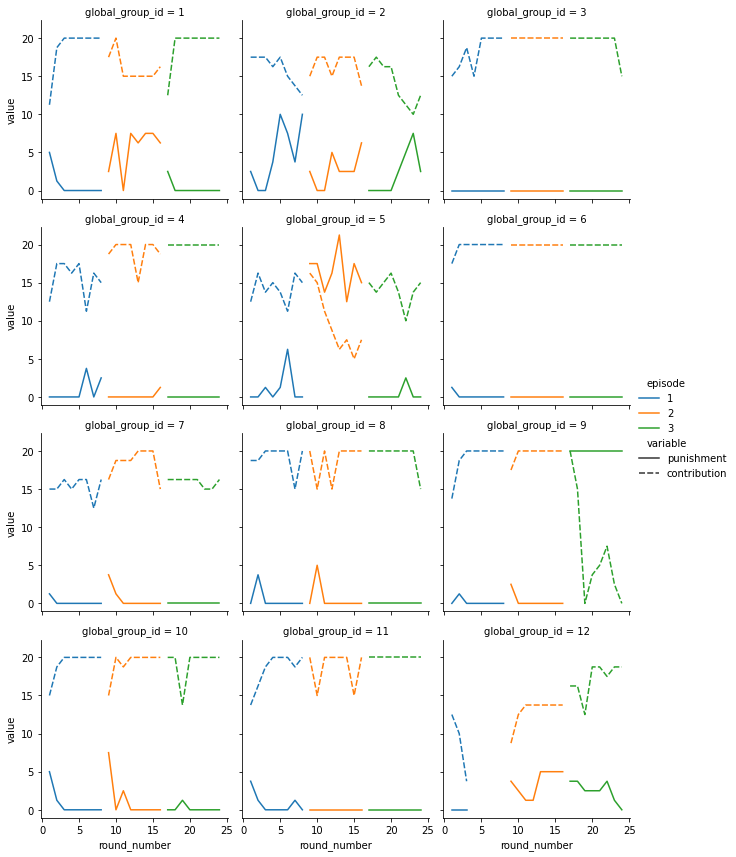

In [127]:
plt.figure(figsize=(14,10))

dfm = df.melt(
    id_vars=['global_group_id', 'round_number', 'participant_code', 'episode','group_duration_min', 'experiment_name'], 
    value_vars=['punishment', 'contribution'])

dfm['episode'] = dfm['episode'].astype(str)

g = sns.relplot(
    data=dfm,
    x="round_number", y="value", col='global_group_id', hue='episode',
    style='variable',
    kind="line", ci=None,
    col_wrap=3, height=3, aspect=1,

)
plt.savefig(os.path.join(plot_folder, 'temporal.jpg'), dpi=300, transparent=False)

<Figure size 576x360 with 0 Axes>

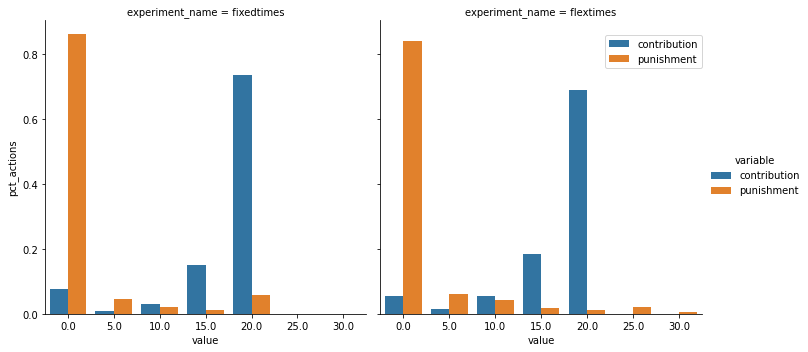

In [138]:
plt.figure(figsize=(8,5))


dfg = dfm.groupby(['experiment_name', 'variable', 'value'])['participant_code'].count()
dfg = dfg / dfg.groupby(['experiment_name','variable']).transform('sum')
dfg = dfg.reset_index()

dfg = dfg.rename(columns={'participant_code': 'pct_actions'})


sns.catplot(x="value", y='pct_actions', hue="variable", col='experiment_name', data=dfg, kind="bar",)
plt.legend(bbox_to_anchor=(0.7, 0.95), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(plot_folder, 'contribution_punishments.jpg'), dpi=300, transparent=False)

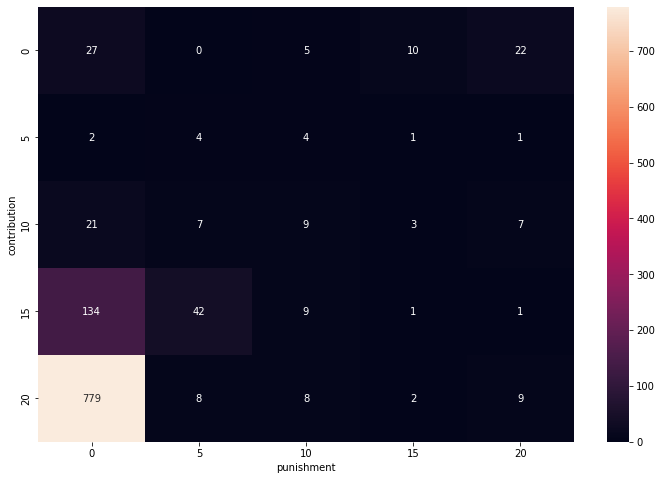

In [129]:
plt.figure(figsize=(12,8))
pt = df.pivot_table(index='contribution', columns='punishment', values='participant_code', aggfunc='count')
pt = pt.reindex(columns=range(0,25,5), index=range(0,25,5)).fillna(0).astype(int)
sns.heatmap(pt, annot=True, fmt='d')
plt.savefig(os.path.join(plot_folder, 'contribution_punishments_matrix.jpg'), dpi=300, transparent=False)

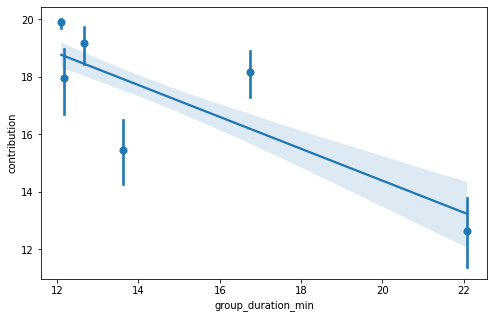

In [130]:
plt.figure(figsize=(8,5))

where = df['experiment_name'] == 'flextimes'

sns.regplot(y="contribution", x="group_duration_min", data=df[where], x_bins=8)
plt.savefig(os.path.join(plot_folder, 'group_performance_time.jpg'), dpi=300, transparent=False)

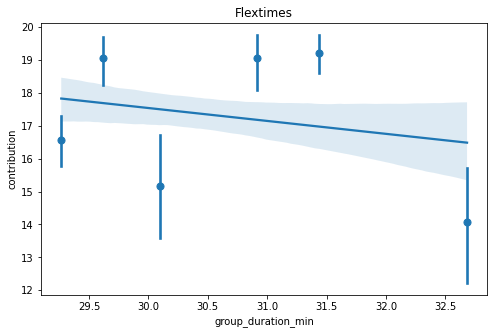

In [139]:
plt.figure(figsize=(8,5))

where = df['experiment_name'] == 'fixedtimes'

plt.title('Flextimes')
sns.regplot(y="contribution", x="group_duration_min", data=df[where], x_bins=8)
plt.savefig(os.path.join(plot_folder, 'group_performance_time.jpg'), dpi=300, transparent=False)

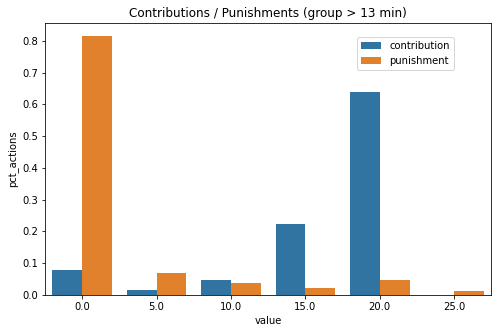

In [134]:
plt.figure(figsize=(8,5))

where = (
    dfm['experiment_name'] == 'flextimes') & (dfm['group_duration_min'] > 13
)

dfg = dfm[dfm['group_duration_min'] > 13].groupby(['variable', 'value'])['participant_code'].count()
dfg = dfg / dfg.groupby('variable').transform('sum')
dfg = dfg.reset_index()

dfg = dfg.rename(columns={'participant_code': 'pct_actions'})

sns.barplot(x="value", hue="variable", y='pct_actions', data=dfg, )
plt.legend(bbox_to_anchor=(0.7, 0.95), loc=2, borderaxespad=0.)
plt.title('Contributions / Punishments (group > 13 min)')
plt.savefig(os.path.join(plot_folder, 'contribution_punishments_slow_groups.jpg'), dpi=300, transparent=False)